#### Importing Libraries and built-in Models from Tensorflow

In [64]:
import os
import gc
import cv2
import time
import itertools
import sklearn

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from keras import backend as K
from matplotlib import pyplot as plt

from glob import glob
from tqdm import tqdm
from itertools import cycle
from tabulate import tabulate
from pandas import DataFrame
from keras import regularizers, optimizers, initializers

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from keras.models import Sequential, Model
from keras.layers.core import Dense
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator

from keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
)
from sklearn.metrics import (
    roc_curve, auc, multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report, confusion_matrix
)
from tensorflow.keras.applications import (
    VGG16, VGG19, InceptionV3, Xception, DenseNet121, ResNet50V2, MobileNet, MobileNetV2, EfficientNetB0, EfficientNetB1, 
    EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
)

In [65]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

#### Defining helping functions.
* calculate_cm returns true_positives, false_positives, false_negatives and true_negatives, for Binary Classification Problem.
* calculate_recall returns value of Recall evaluation measure, for Binary Classification Problem.
* calculate_fallout returns false_positive_rate, for Binary Classification Problem.
* calculate_fpr_tpr returns false_positve_rate and true_positive_rate, for Binary Classification Problem.

In [66]:
def calculate_cm(y_true, y_pred):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    return tp, fp, fn, tn

def calculate_recall(tp, fp, fn, tn):
    return (tp)/(tp + fn)

def calculate_fallout(tp, fp, fn, tn):
    return (fp)/(fp + tn)

def calculate_fpr_tpr(y_true, y_pred):
    tp, fp, fn, tn = calculate_cm(y_true, y_pred)
    tpr = calculate_recall(tp, fp, fn, tn)
    fpr = calculate_fallout(tp, fp, fn, tn)
    return fpr, tpr

#### Reading Dataset's metadata and Applying One Hot Encoding to the Labels
###### Result: df contains Image_Names, Image_Paths and Columns for each class label with one hot encoded values

In [67]:
image_paths = {os.path.basename(x): x for x in glob(os.path.join('.', 'images', '*.png'))}
df = pd.read_csv("./dataset_information/Data_Entry_2017.csv")

df = df.drop(
    columns = [
        "Follow-up #", 
        "Patient ID", 
        "Patient Age", 
        "Patient Gender", 
        "OriginalImage[Width",
        "Height]",
        "OriginalImagePixelSpacing[x",
        "y]",
#         "Unnamed: 11",
        "View Position"
    ], 
    axis = 1
)

df["Image Paths"] = " "
for row_index in tqdm(range(len(df)), ncols = 100):
    img_name = df.iloc[row_index][0]
    path = image_paths[img_name]
    df["Image Paths"][row_index] = path

unique_labels = set(itertools.chain.from_iterable(df["Finding Labels"].apply(lambda x : x.split('|')).values)) 
one_hot_labels = pd.DataFrame(0.0, index = np.arange(len(df)), columns = unique_labels)

for index, row in df.iterrows():
    labels = row["Finding Labels"].split('|')
    for label in labels:
        one_hot_labels.iloc[index][label] = 1.0

df = pd.concat([df, one_hot_labels], axis = 1)
df = df.drop(columns = ["Finding Labels"], axis = 1)
df.head(3)

100%|█████████████████████████████████████████████████████| 112120/112120 [01:09<00:00, 1620.18it/s]


,Image Index,Image Paths,Emphysema,Pneumothorax,Pneumonia,Consolidation,No Finding,Infiltration,Fibrosis,Cardiomegaly,Effusion,Nodule,Pleural_Thickening,Edema,Atelectasis,Mass,Hernia
0,00000001_000.png,.\images\00000001_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,.\images\00000001_001.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,.\images\00000001_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Division of dataset into Training, Validation and Testing subsets
* 70 % data for Training
* 10 % data for Validation
* 20 % data for Testing

In [68]:
# df_train, df_test = train_test_split(dataset_info.sample(n = 60000), test_size = 0.20, random_state = 142)
df_train, df_test = train_test_split(df, test_size = 0.20, random_state = 0)
df_train, df_val = train_test_split(df_train, test_size = 0.10, random_state = 0)

print(f"Training Samples: {len(df_train)}\nValidation Samples: {len(df_val)}\nTesting Samples: {len(df_test)}")

Training Samples: 80726
Validation Samples: 8970
Testing Samples: 22424


#### Defined Hyperparameters (Constants) for the entire Machine Learnin Pipeline
* CLASS_LABEL - Classes' names to use for traning and testing
* IMAGE_SIZE - Resolution of images used
* BATCH_SIZE - Size of mini-batches to use for backpropagation
* EPOCHS - Number of epochs to train the model for
* LEARNING_RATE - LR to use in optimizer algorithm while training
* BETA_FOR_BIASED_RECALL - Beta value that gives more imporance to recall in F-Beta Score
* BETA_FOR_BIASED_PRECISION - Beta value that gives more imporance to precision in F-Beta Score
* BETA_WITH_NO_BIAS - Beta value that gives equal imporance to recall and precision in F-Beta Score
* THRESHOLDS - Values of thresholds to use for metrices such as AUC

In [69]:
CLASS_LABELS = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", 
    "Infiltration", "Mass", "No Finding", "Nodule", "Pleural_Thickening", "Pneumonia","Pneumothorax"
]
IMAGE_SIZE = (224, 224,)
BATCH_SIZE = 24
EPOCHS = 10
LEARNING_RATE = 0.0001

BETA_FOR_BIASED_RECALL = 1.3
BETA_FOR_BIASED_PRECISION = 0.7
BETA_WITH_NO_BIAS = 1

THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [70]:
def plot_class_samples(samples_count):
    labels = list(samples_count.keys())
    count = list(samples_count.values())
    
    plt.rcParams['figure.dpi'] = 150
    fig, ax = plt.subplots(figsize =(18, 8))
    ax.barh(labels, count)
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 2)
    ax.yaxis.set_tick_params(pad = 3)
    
    # Add x, y gridlines
    ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
    
    # Show top values
    ax.invert_yaxis()
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(
            i.get_width() + 0.2, 
            i.get_y() + 0.5, 
            str(round((i.get_width()), 2)), 
            fontsize = 10, 
            fontweight = 'bold', 
            color ='grey'
        )
    
    ax.set_title('Samples Belonging to Each Class Label', loc ='center')
    plt.show()

In [71]:
SAMPLES_PER_CLASS = dict()

for label in CLASS_LABELS:
    SAMPLES_PER_CLASS[label] = 0

for label in CLASS_LABELS:
    SAMPLES_PER_CLASS[label] = int(df[label].sum())
    
# plot_class_samples(SAMPLES_PER_CLASS)

In [72]:
SORTED_SAMPLES_PER_CLASS = dict(sorted(SAMPLES_PER_CLASS.items(), key=lambda x:x[1], reverse = True))
keys = list(SORTED_SAMPLES_PER_CLASS.keys())
values = list(SORTED_SAMPLES_PER_CLASS.values())

# sns.set(rc = {'figure.figsize' : (10, 4)})
# sns.barplot(x = values, y = keys, color = "green")

In [73]:
del(SORTED_SAMPLES_PER_CLASS["No Finding"])
keys = list(SORTED_SAMPLES_PER_CLASS.keys())
values = list(SORTED_SAMPLES_PER_CLASS.values())

# sns.barplot(x = values, y = keys, color = "green")

In [74]:
CLASS_WEIGHTS = dict()
label_with_most_samples = max(SAMPLES_PER_CLASS, key = SAMPLES_PER_CLASS.get)

for index, label in enumerate(CLASS_LABELS):
    CLASS_WEIGHTS[index] = SAMPLES_PER_CLASS[label_with_most_samples] / (len(CLASS_LABELS) * SAMPLES_PER_CLASS[label])

tabulated_weights_data = []    
for i in range(15):
    row = [CLASS_LABELS[i], SAMPLES_PER_CLASS[CLASS_LABELS[i]], CLASS_WEIGHTS[i]]
    tabulated_weights_data.append(row)
    
print(tabulate(
    tabulated_weights_data, 
    headers = ["Class Name", "Samples", "Weightage"], 
    tablefmt = "github", 
    numalign = "left"
))

| Class Name         | Samples   | Weightage   |
|--------------------|-----------|-------------|
| Atelectasis        | 11535     | 0.349152    |
| Cardiomegaly       | 2772      | 1.45291     |
| Consolidation      | 4667      | 0.862967    |
| Edema              | 2303      | 1.74879     |
| Effusion           | 13307     | 0.302658    |
| Emphysema          | 2516      | 1.60074     |
| Fibrosis           | 1686      | 2.38877     |
| Hernia             | 227       | 17.7421     |
| Infiltration       | 19870     | 0.202691    |
| Mass               | 5746      | 0.700917    |
| No Finding         | 60412     | 0.0666667   |
| Nodule             | 6323      | 0.636955    |
| Pleural_Thickening | 3385      | 1.1898      |
| Pneumonia          | 1353      | 2.97669     |
| Pneumothorax       | 5298      | 0.760186    |


In [75]:
def apply_sharpening(image):
    sharp_kernel = np.array(
        [
            [0, -1, 0], 
            [-1, 5, -1], 
            [0, -1, 0]
        ])
    output = cv2.filter2D(src = image, ddepth = -1, kernel = sharp_kernel)
    return output

def apply_min_max_scaling(image):
    image = (image - image.min()) / (image.max() - image.min())
    image = rescale(image, 0.25, multichannel = True, mode = "constant")
    return image

In [76]:
train_data_generator = ImageDataGenerator(
    rescale = 1. / 255,
    preprocessing_function = apply_sharpening,
    shear_range = 0.2,
    horizontal_flip = True
)
val_data_generator = ImageDataGenerator(rescale = 1. / 255, preprocessing_function = apply_sharpening)
test_data_generator = ImageDataGenerator(rescale = 1. / 255, preprocessing_function = apply_sharpening)

def flow_from_dataframe(image_generator, dataframe):
    df_gen = image_generator.flow_from_dataframe(
        dataframe,
        x_col = "Image Paths", 
        y_col = dataframe.columns[2:],
        target_size = IMAGE_SIZE,
        color_mode = 'rgb',
        class_mode = 'raw',
        shuffle = False,
        batch_size = BATCH_SIZE
    )
    return df_gen

train_gen = flow_from_dataframe(image_generator = train_data_generator, dataframe = df_train)
valid_gen = flow_from_dataframe(image_generator = val_data_generator, dataframe = df_val)
test_gen = flow_from_dataframe(image_generator = test_data_generator, dataframe = df_test)

Found 80726 validated image filenames.
Found 8970 validated image filenames.
Found 22424 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


224


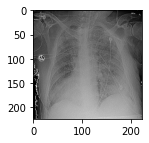

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


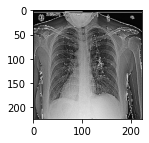

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


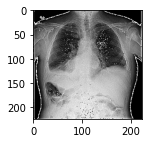

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


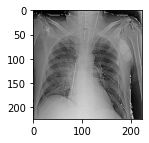

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


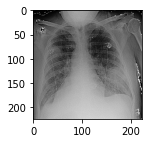

In [77]:
plt.rcParams["figure.figsize"] = (2,2)

x = train_gen.next()
print(len(x[0][0]))

for i in range(1):
    for j in range(5):
        image = x[i][j]
        plt.imshow(image)
        plt.imshow((image * 255).astype(np.uint8))
        plt.show()

#### Defined Callbacks for model while training
* Early Stopping

In [78]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 4,
    verbose = 1,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True
)

#### Defined Metrices to monitor in training and evaluation phase
* True Positives
* False Positives
* True Negatives
* False Negatives
* Binary Accuracy 
* Recall
* Precision
* AUC (ROC) - Multi-Label
* AUC (PR)

In [79]:
METRICS = [
  tf.keras.metrics.TruePositives(name = 'tp'),
  tf.keras.metrics.FalsePositives(name = 'fp'),
  tf.keras.metrics.TrueNegatives(name = 'tn'),
  tf.keras.metrics.FalseNegatives(name = 'fn'), 
  tf.keras.metrics.BinaryAccuracy(name = 'binary_accuracy'),
  tf.keras.metrics.Precision(name = 'precision', thresholds = 0.3),
  tf.keras.metrics.Recall(name = 'recall', thresholds = 0.3),
  tf.keras.metrics.AUC(name = 'auc', multi_label = True, num_labels = 15, thresholds = THRESHOLDS),
  tf.keras.metrics.AUC(name = 'prc', curve = 'PR')
]

#### Class for Multi-Label Binary Cross Entropy with Positive/Negative Weighting

In [94]:
class MultiLabelCrossEntropy:
    def __init__(self, labels: DataFrame, epsilon = 1e-7):
        self.epsilon = epsilon
        self.N = labels.shape[0]
        self.freq_p = np.sum(labels == 1, axis=0)
        self.freq_n = np.sum(labels == 0, axis=0)
        self.freq_pos = np.sum(labels == 1, axis=0) / self.N
        self.freq_neg = np.sum(labels == 0, axis=0) / self.N
        self.pos_weights = self.freq_neg
        self.neg_weights = self.freq_pos
        
        self.tabulated_weights_data = []
        for i in range(15):
            row = [CLASS_LABELS[i], self.freq_p[i], self.freq_n[i], self.pos_weights[i], self.neg_weights[i]]
            self.tabulated_weights_data.append(row)
            
        print(tabulate(
            self.tabulated_weights_data, 
            headers = ["Class Name", "Positive Frequency", "Negative Frequency", "Positive Weight", "Negative Weight"], 
            tablefmt = "github", 
            numalign = "left"
        ))
        
    def contribution(self):
        return self.freq_pos * self.pos_weights, self.freq_neg * self.neg_weights
        
    def calculate_loss(self, true_y, pred_y):
        loss = 0.0
        for i in range(len(self.pos_weights)):
            loss += (-1 * K.mean(self.pos_weights[i] * true_y[:,i] * K.log(pred_y[:,i] + self.epsilon))) + (-1 * K.mean(self.neg_weights[i] * (1 - true_y[:,i]) * K.log(1 - pred_y[:,i] + self.epsilon)))
        return loss

In [95]:
MLCE_Loss_With_Class_Weights = MultiLabelCrossEntropy(df_train[CLASS_LABELS])

| Class Name         | Positive Frequency   | Negative Frequency   | Positive Weight   | Negative Weight   |
|--------------------|----------------------|----------------------|-------------------|-------------------|
| Atelectasis        | 8276                 | 72450                | 0.89748           | 0.10252           |
| Cardiomegaly       | 2015                 | 78711                | 0.975039          | 0.024961          |
| Consolidation      | 3324                 | 77402                | 0.958824          | 0.0411763         |
| Edema              | 1656                 | 79070                | 0.979486          | 0.0205138         |
| Effusion           | 9717                 | 71009                | 0.87963           | 0.12037           |
| Emphysema          | 1758                 | 78968                | 0.978223          | 0.0217774         |
| Fibrosis           | 1213                 | 79513                | 0.984974          | 0.0150261         |
| Hernia           

#### Defined Optimizers and Losses Dictionaries
##### Optimizers
* Stochastic Gradient Descent (SGD)
* Adaptive Moment Estimation (Adam)

##### Losses
* Binary Cross Entropy
* Class Weighted Binary Cross Entropy for Multi-Label Classification

In [96]:
DEFINED_OPTIMIZERS = {
    "SGD" : tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE, decay = 1e-6, momentum = 0.9, nesterov = True),
    "ADAM" : tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999,)
}

DEFINED_LOSSES = {
    "BCE" : "binary_crossentropy", 
    "MLBCE_CW" : MLCE_Loss_With_Class_Weights.calculate_loss
}

#### Model Initialization and Compilation with decided parameters

In [97]:
channels = (3,)
input_shape = IMAGE_SIZE + channels
img_input = Input(shape = input_shape)

MODEL_NAME = "MobileNet"
base_model = MobileNet(
    input_shape = input_shape,
    include_top = False,
    weights = "imagenet"
)

classifier = Sequential()
classifier.add(GlobalAveragePooling2D(input_shape = base_model.output_shape[1:]))
classifier.add(Dropout(0.2))

classifier.add(Dense(256))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.2))

classifier.add(Dense(50))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.2))

classifier.add(Dense(15, activation = "sigmoid"))

model = Model(inputs = base_model.input, outputs = classifier(base_model.output))
# model.load_weights(f"./saved_weights/{MODEL_NAME}_{EPOCHS}_weights.h5")

model.compile(
    optimizer = DEFINED_OPTIMIZERS["ADAM"],
    loss = DEFINED_LOSSES["MLBCE_CW"],
    metrics = METRICS,
)

USE_CLASS_WEIGHTS_IN_MODEL_FIT = False

#### Traning of model for set epochs

In [84]:
start_time = time.time()

history = model.fit(
    epochs = EPOCHS,
    x = train_gen,
    validation_data = valid_gen,  
    steps_per_epoch = train_gen.n / train_gen.batch_size,
    validation_steps = valid_gen.n / valid_gen.batch_size,  
    shuffle = False,
    callbacks = None,
    verbose = 1,
    class_weight = CLASS_WEIGHTS if USE_CLASS_WEIGHTS_IN_MODEL_FIT else None,
)

print(f"\nTime Taken: {(time.time() - start_time) / 3600 : .4f} Hours")

Epoch 1/10
 272/3363 [=>............................] - ETA: 33:08 - loss: 1.5454 - tp: 5790.0000 - fp: 49256.0000 - tn: 40491.0000 - fn: 2383.0000 - binary_accuracy: 0.4726 - precision: 0.0911 - recall: 0.9229 - auc: 0.5606 - prc: 0.1252

KeyboardInterrupt: 

In [ ]:
plt.figure(1, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['loss'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_loss'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(2, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['binary_accuracy'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_binary_accuracy'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Binary Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.show()

plt.figure(3, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['recall'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_recall'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(4, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['precision'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_precision'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.figure(6, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['auc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_auc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

plt.figure(7, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['prc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_prc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation PRC')
plt.xlabel('Epochs')
plt.ylabel('PRC')
plt.legend()
plt.show()

In [ ]:
model.save_weights(f"./saved_weights/{MODEL_NAME}_{EPOCHS}_weights.h5")
evaluation = model.evaluate(test_gen)

In [ ]:
test_loss = evaluation[0]
TP = evaluation[1]
FP = evaluation[2]
TN = evaluation[3]
FN = evaluation[4]
binary_accuracy = evaluation[5] * 100
auc = evaluation[8] * 100
auc_pr = evaluation[9] * 100

specificity = (TN / (TN + FP)) * 100
recall = (TP / (TP + FN)) * 100
precision = (TP / (TP + FP)) * 100
f1_score = (2 * recall * precision) / (recall + precision)

print(f"Testing Loss: \t\t{test_loss}\n")
print(f"True Positives: \t{TP}\nFalse Positives: \t{FP}\nTrue Negatives: \t{TN}\nFalse Negatives: \t{FN}\n")
print(f"Binary Accuracy: \t{binary_accuracy}")
print(f"Average Recall: \t{recall}\nAverage Precision: \t{precision}\nF1-Score: \t\t{f1_score}\nAverage Specificity: \t{specificity}\n")
print(f"AUC: \t\t\t{auc}\nAUC-PR: \t\t{auc_pr}")

In [ ]:
test_gen.reset()
predictions = model.predict(test_gen)

In [ ]:
def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score
    
def print_results(beta, threshold, test_labels, prediction):
    accuracy = K.eval(binary_accuracy(K.variable(value = test_labels), K.variable(value = prediction)))
    precision = K.eval(precision_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    recall = K.eval(recall_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    f1_score = K.eval(fbeta_score_threshold(beta = beta, threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    print(f"BETA: {beta}, THRESHOLD: {threshold}")
    print (f"Binary Accuracy: \t{accuracy * 100} % \nRecall: \t\t{recall * 100} % \nPrecision: \t\t{precision * 100} % \nF1-Score: \t\t{f1_score * 100} %\n")

In [ ]:
test_labels = []
for label in test_gen.labels:
    test_labels.append(label)

# # Results with F Score giving more weightage to Recall
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_RECALL, threshold = threshold, test_labels = test_labels, prediction = predictions)

# # Results with F Score giving more weightage to Precision
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_PRECISION, threshold = threshold, test_labels = test_labels, prediction = predictions)

# Results with F Score giving equal weightage to Recall and Precision
for threshold in THRESHOLDS:
    print_results(beta = BETA_WITH_NO_BIAS, threshold = threshold, test_labels = test_labels, prediction = predictions)

In [ ]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix - " + class_label)

In [ ]:
threshold = 0.3
y_test = test_gen.labels
y_predicted = (predictions >= threshold).astype(int)
confusion_matrix = multilabel_confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots(3, 5, figsize=(22, 10))
for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, CLASS_LABELS):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 150

colors = cycle(['blue', 'red', 'green', 'black', 'purple', 'magenta', 'cyan', 'orange', 'teal', 'darkgreen'])
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2

for i in range(len(CLASS_LABELS)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

avg_auc = 0
for auc_value in roc_auc.values():
    avg_auc += auc_value
print(f"[{MODEL_NAME} with {EPOCHS} Epochs] - Average AUC: {avg_auc / 15}")
    
for i, color in zip(range(len(CLASS_LABELS)), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = 2, label = '{0} (AUC = {1:0.2f})'''.format(CLASS_LABELS[i], roc_auc[i]))

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - {MODEL_NAME} with {EPOCHS} Epochs')
plt.legend(loc = "lower right")
plt.show()